In [1]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
import mysql.connector
import pandas as pd
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score,

In [2]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}
#pg = ProxyGenerator()

# Create training dataset

In [20]:
test_papers = []
with open(r'./test_papers.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        test_papers.append(x)

train_papers = []
with open(r'./train_papers.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        train_papers.append(x)
#in_params_train = ','.join(['%s'] * len(train_papers))

In [21]:
train_index = len(train_papers)
complete_set = train_papers + test_papers
in_params = ','.join(['%s'] * len(complete_set))

In [22]:
cursor.execute("select p.PaperID, a.Gender, aff.Country, aff.Name, p.`primary author`, GROUP_CONCAT(a2.Gender), GROUP_CONCAT(aff2.Country), GROUP_CONCAT(aff2.Name), GROUP_CONCAT(p2.`primary author`) from Papers p, Authors a, affiliatedTo af, Affiliations aff, referencedBy b, Papers p2, Authors a2, affiliatedTo af2, Affiliations aff2 where p.PaperID in (%s) and p.`primary author` = a.AuthorID and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a2.AuthorID and a.AuthorID = af.AuthorID and af.affiliatedTo = aff.AffiliationID and a2.AuthorID = af2.AuthorID and af2.affiliatedTo = aff2.AffiliationID  group by p.PaperID, a.Gender, aff.Country, aff.AffiliationID" % in_params, complete_set)
complete_information = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "Gender", "Country", "Affiliation", "Author", "Gender_references", "Country_references", "Affiliation_references", "Author_references"])
cursor.execute("select p.PaperID, group_concat(aff.AffiliationID), group_concat(aff.Country), group_concat(a.AuthorID) from Papers p, authoredBy b, Authors a, affiliatedTo af, Affiliations aff where p.PaperID in (%s) and p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.AuthorID = af.AuthorID and af.affiliatedTo = aff.AffiliationID group by p.PaperID" % in_params, complete_set)
authors_country_affiliation = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "author_affiliations", "author_countries", "author_authors"])
#authors_country_affiliation
complete_information = pd.merge(authors_country_affiliation, complete_information, on="PaperID")

In [23]:
train_indexes = complete_information[complete_information["PaperID"].isin(train_papers)].index
test_indexes = complete_information[complete_information["PaperID"].isin(test_papers)].index

# Logistic Regression

## Gender

In [24]:
#gender_prediction = pd.DataFrame(columns=["target", "gender"])
gender_prediction_list = []
for idx, information in complete_information.iterrows():
    total_gender = information["Gender_references"].split(",")
    paperID = information["PaperID"]
    fem_distribution = np.count_nonzero(np.array(total_gender, dtype="int"))/len(total_gender)
    cited_gender = {"target": information["Gender"], "gender": fem_distribution}
    #new_row = pd.DataFrame([list(cited_gender.values())], columns=cited_gender.keys())
    #gender_prediction = pd.concat([gender_prediction, new_row], ignore_index=True)
    gender_prediction_list.append(cited_gender)
gender_prediction = pd.DataFrame(gender_prediction_list)

In [25]:
target_gender = gender_prediction["target"]
input_gender = gender_prediction["gender"]
train_targets_gender = target_gender[train_indexes].astype("int")
train_inputs_gender = input_gender[train_indexes].to_numpy().reshape(-1,1)
test_targets_gender = target_gender[test_indexes].astype("int")
test_inputs_gender = input_gender[test_indexes].to_numpy().reshape(-1,1)

In [138]:
ros_gender = RandomUnderSampler(random_state=42)
X_gender_resampled, y_gender_resampled = ros_gender.fit_resample(train_inputs_gender, train_targets_gender)

In [139]:
lr_gender = LogisticRegression()
lr_gender.fit(X_gender_resampled, y_gender_resampled)

LogisticRegression()

In [140]:
rfc_gender = RandomForestClassifier()
rfc_gender.fit(train_inputs_gender, train_targets_gender)

RandomForestClassifier()

In [141]:
filtered_gender_test_set = pd.concat([input_gender[test_indexes], target_gender[test_indexes]], axis=1)
filtered_gender_test_set = filtered_gender_test_set.loc[-((filtered_gender_test_set["target"]==0) & (filtered_gender_test_set["gender"]>0.2))]
filtered_input = filtered_gender_test_set["gender"].to_numpy().reshape(-1,1)
filtered_target = filtered_gender_test_set["target"].to_numpy().reshape(-1,1)

In [186]:
gender_accuracy_lr = lr_gender.score(test_inputs_gender,test_targets_gender)
gender_accuracy_rfc = rfc_gender.score(test_inputs_gender,test_targets_gender)
gender_precision = precision_score(rfc_gender.predict(test_inputs_gender), np.zeros(len(test_targets_gender)))
gender_recall = recall_score(rfc_gender.predict(test_inputs_gender), np.zeros(len(test_targets_gender)))
gender_auc = roc_auc_score(rfc_gender.predict(test_inputs_gender), np.zeros(len(test_targets_gender)))
gender_f1 = f1_score(rfc_gender.predict(test_inputs_gender), np.zeros(len(test_targets_gender)))


#print(f"Accuracy: {gender_accuracy}; Precision: {gender_precision}; Recall: {gender_recall}")
gender_accuracy_lr, gender_accuracy_rfc, gender_precision, gender_recall, gender_auc, gender_f1

/home/david/PycharmProjects/bachelor_thesis/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5795228628230616, 0.8151093439363817, 0.0, 0.0, 0.5, 0.0)

In [188]:
1-(np.count_nonzero(test_targets_gender)/len(test_targets_gender))

0.8359840954274353

In [143]:
lr_gender.coef_, lr_gender.intercept_

(array([[2.56750275]]), array([-0.41062565]))

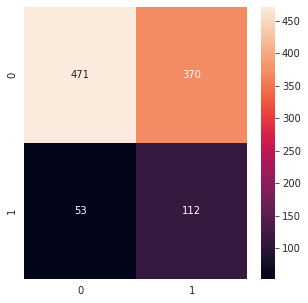

In [144]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

cm = confusion_matrix(test_targets_gender, lr_gender.predict(test_inputs_gender))
sn.heatmap(cm, ax=ax1, annot=True, fmt='g')

#ax1.xlabel('Predicted Label')
plt.show()

## Why is the accuracy that low?

In [95]:
male_distribution = train_inputs_gender[(train_targets_gender == 0)]
female_distribution = train_inputs_gender[(train_targets_gender == 1)]
male_distribution_test = test_inputs_gender[(test_targets_gender == 0)]
female_distribution_test = test_inputs_gender[(test_targets_gender == 1)]

In [96]:
t_statistic, p_value = ttest_ind(np.array(male_distribution, dtype="float32"), np.array(female_distribution, dtype="float32"), equal_var=True)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: [-6.58947]
p-value: [5.414857e-11]


In [336]:
#np.mean(male_distribution_test), np.mean(female_distribution_test)

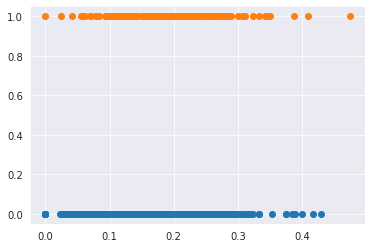

In [105]:
plt.Figure(figsize=(20, 10))
plt.scatter(male_distribution_test, np.zeros(len(male_distribution_test)))
plt.scatter(female_distribution_test, np.ones(len(female_distribution_test)))
plt.show()

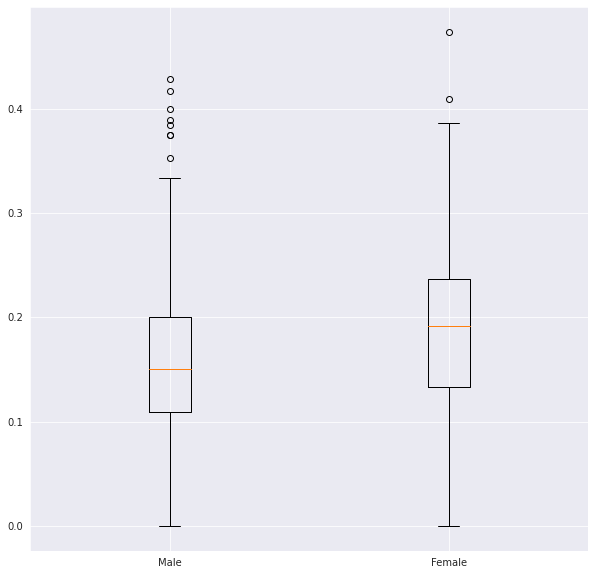

In [98]:
data = [male_distribution_test.flatten(), female_distribution_test.flatten()]
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(data)
ax.set_xticklabels(['Male', 'Female'])
plt.show()


## Countries

In [42]:
all_countries = set()
for countries in complete_information["Country_references"]:
    all_countries.update(countries.split(","))

In [43]:
columns = list(all_countries).append("target")
country_prediction_list = []
for idx, information in complete_information.iterrows():
    target = information["Country"]
    cited_countries = Counter(information["Country_references"].split(","))
    cited_countries["target"] = target
    country_prediction_list.append(cited_countries)
country_prediction = pd.DataFrame(country_prediction_list)
country_prediction = country_prediction.fillna(0)

In [44]:
target_countries = country_prediction["target"]
input_countries = country_prediction.drop(["target"], axis=1)
input_countries = input_countries.div(input_countries.sum(axis=1), axis=0)

In [45]:
train_targets = target_countries[train_indexes]
train_inputs = input_countries.loc[train_indexes]
test_targets = target_countries[test_indexes]
test_inputs = input_countries.loc[test_indexes]

In [46]:
most_represented_countries = [x[0] for x in list(filter(lambda x: x[1] >= 0, dict(Counter(list(train_targets))).items()))]

country_target_train_indexes = train_targets[train_targets.isin(most_represented_countries)].index
train_targets = train_targets[country_target_train_indexes]
train_inputs = train_inputs.loc[country_target_train_indexes]

country_target_test_indexes = test_targets[test_targets.isin(most_represented_countries)].index
test_targets = test_targets[country_target_test_indexes]
test_inputs = test_inputs.loc[country_target_test_indexes]


In [47]:
dict(Counter(list(train_targets))).items()

dict_items([('United States', 547), ('Australia', 97), ('Germany', 123), ('Japan', 60), ('Italy', 51), ('South Korea', 82), ('India', 35), ('Romania', 5), ('China', 690), ('Macao', 7), ('Hong Kong', 161), ('Singapore', 69), ('United Kingdom', 105), ('Switzerland', 77), ('Moldova', 2), ('Czechia', 10), ('Spain', 15), ('Turkey', 13), ('Austria', 15), ('Finland', 17), ('Taiwan', 23), ('Netherlands', 11), ('France', 51), ('Canada', 43), ('Portugal', 3), ('United Arab Emirates', 2), ('Denmark', 4), ('Saudi Arabia', 8), ('Russia', 9), ('Brazil', 7), ('Morocco', 3), ('Sweden', 7), ('Vietnam', 2), ('Slovenia', 7), ('Iran', 4), ('Bangladesh', 2), ('Iraq', 2), ('New Zealand', 2), ('Greece', 2), ('Norway', 3), ('Israel', 4), ('Sri Lanka', 2), ('Chile', 3)])

In [48]:
undersample_set_countries = {x[0]: 50 for x in list(filter(lambda x: x[1] > 50, dict(Counter(list(train_targets))).items()))}

In [49]:
#ros = RandomUnderSampler(sampling_strategy=undersample_set_countries)
#X_resampled, y_resampled = ros.fit_resample(train_inputs, train_targets)

ros = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = ros.fit_resample(train_inputs, train_targets)

In [263]:
lr = LogisticRegression(max_iter=1000)
lr.fit(train_inputs, train_targets)
lr_resampled = LogisticRegression(max_iter=1000)
lr_resampled.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [50]:
rfc_country_resampled = RandomForestClassifier(random_state=42)
rfc_country_resampled.fit(X_resampled, y_resampled)
rfc_country = RandomForestClassifier(random_state=42)
rfc_country.fit(train_inputs, train_targets)

RandomForestClassifier(random_state=42)

In [265]:
"""
total = 0
hit = 0
multi_target =complete_information.loc[test_indexes]["author_countries"]
for idx, prediction in enumerate(lr_resampled.predict(test_inputs)):
    print(multi_target.iloc[idx])
    if prediction in multi_target["author_countries"].iloc[idx].split(","):
        hit += 1
    total += 1
"""

'\ntotal = 0\nhit = 0\nmulti_target =complete_information.loc[test_indexes]["author_countries"]\nfor idx, prediction in enumerate(lr_resampled.predict(test_inputs)):\n    print(multi_target.iloc[idx])\n    if prediction in multi_target["author_countries"].iloc[idx].split(","):\n        hit += 1\n    total += 1\n'

In [52]:
#lr.score(test_inputs, test_targets),
rfc_country_resampled.score(test_inputs, test_targets), rfc_country.score(test_inputs, test_targets)

(0.43737574552683894, 0.44930417495029823)

In [54]:
precision_country = precision_score(rfc_country_resampled.predict(test_inputs), test_targets, average="macro")
recall_country = recall_score(rfc_country_resampled.predict(test_inputs), test_targets, average="macro")
f1_country = f1_score(rfc_country_resampled.predict(test_inputs), test_targets, average="macro")
#auc_country = roc_auc_score(rfc_country.predict(test_inputs), test_targets)
precision_country, recall_country, f1_country

/home/david/PycharmProjects/bachelor_thesis/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.24284761212382672, 0.3485508450355169, 0.25908376883394196)

In [245]:
test_targets

2       United States
6               China
15              China
16              China
18          Hong Kong
            ...      
3378            China
3381        Hong Kong
3382    United States
3386    United States
3387            China
Name: target, Length: 891, dtype: object

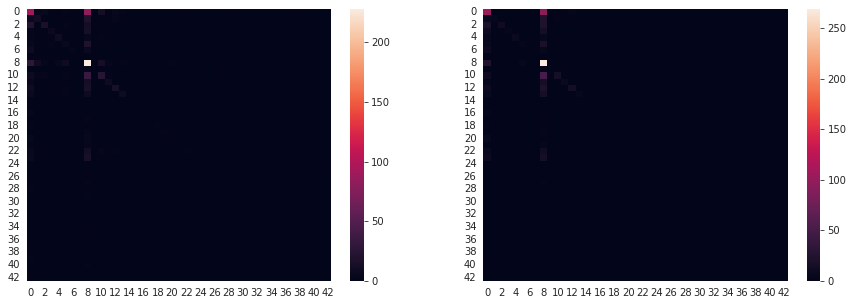

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(test_targets, rfc_country.predict(test_inputs), labels=most_represented_countries)
sn.heatmap(cm, ax=ax1)

cm = confusion_matrix(test_targets, rfc_country_resampled.predict(test_inputs), labels=most_represented_countries)
sn.heatmap(cm, ax=ax2)

#ax1.xlabel('Predicted Label')
plt.show()

## Affiliation

In [36]:
all_affiliations = set()
for affiliations in complete_information["Affiliation_references"]:
    all_affiliations.update(affiliations.split(","))

In [37]:
columns = list(all_affiliations).append("target")
affiliation_prediction_list = []
for idx, information in complete_information.iterrows():
    target = information["Affiliation"]
    cited_affiliations = Counter(information["Affiliation_references"].split(","))
    cited_affiliations["target"] = target
    affiliation_prediction_list.append(cited_affiliations)
affiliation_prediction = pd.DataFrame(affiliation_prediction_list)
affiliation_prediction = affiliation_prediction.fillna(0)

In [270]:
#most_represented_affiliations = [x[0] for x in list(filter(lambda x: x[1] >= 5, dict(Counter(list(affiliation_prediction["target"]))).items()))]
#affiliation_prediction = affiliation_prediction[affiliation_prediction["target"].isin(most_represented_affiliations)]
target_affiliations = affiliation_prediction["target"]
input_affiliations = affiliation_prediction.drop(["target"], axis=1)
input_affiliations = input_affiliations.div(input_affiliations.sum(axis=1), axis=0)

In [300]:
train_targets_aff = target_affiliations[train_indexes]
train_inputs_aff = input_affiliations.iloc[train_indexes]
test_targets_aff = target_affiliations[test_indexes]
test_inputs_aff = input_affiliations.iloc[test_indexes]
len_train_targets_aff = len(train_targets_aff)

In [303]:
most_represented_affiliations = [x[0] for x in list(filter(lambda x: x[1] >= 3, dict(Counter(list(train_targets_aff))).items()))]

affiliation_target_train_indexes = train_targets_aff[train_targets_aff.isin(most_represented_affiliations)].index
train_targets_aff = train_targets_aff[affiliation_target_train_indexes]
train_inputs_aff = train_inputs_aff.loc[affiliation_target_train_indexes]

affiliation_target_test_indexes = test_targets_aff[test_targets_aff.isin(most_represented_affiliations)].index
test_targets_aff = test_targets_aff[affiliation_target_test_indexes]
test_inputs_aff = test_inputs_aff.loc[affiliation_target_test_indexes]

In [304]:
len(train_targets_aff)/len_train_targets_aff

0.9060796645702306

In [305]:
ros = SMOTE(random_state=42, k_neighbors=1)
#ros = RandomOverSampler(random_state=42)
train_inputs_aff_resampled, train_targets_aff_resampled = ros.fit_resample(train_inputs_aff, train_targets_aff)

In [274]:
aff_lr_resampled = LogisticRegression(max_iter=1000)
aff_lr_resampled.fit(train_inputs_aff_resampled, train_targets_aff_resampled)
aff_lr_resampled.score(test_inputs_aff, test_targets_aff)

0.1908548707753479

In [306]:
rfc_aff = RandomForestClassifier(random_state=42)
rfc_aff.fit(train_inputs_aff_resampled, train_targets_aff_resampled)
rfc_aff.score(test_inputs_aff, test_targets_aff)

0.32947976878612717

In [307]:
precision_country = precision_score(rfc_aff.predict(test_inputs_aff), test_targets_aff, average="macro")
recall_country = recall_score(rfc_aff.predict(test_inputs_aff), test_targets_aff, average="macro")
f1_country = f1_score(rfc_aff.predict(test_inputs_aff), test_targets_aff, average="macro")
#auc_country = roc_auc_score(rfc_country.predict(test_inputs), test_targets)
precision_country, recall_country, f1_country

/home/david/PycharmProjects/bachelor_thesis/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.34795606327311135, 0.30146840289062926, 0.28964798948392356)

## Author

### Create Dataset

In [30]:
all_authors = set()
for authors in complete_information["Author_references"]:
    all_authors.update(authors.split(","))

In [31]:
columns = list(all_authors).append("target")
cited_authors_list = []
author_prediction = pd.DataFrame(columns=columns)
for idx, information in complete_information.iterrows():
    target = information["Author"]
    cited_authors = Counter(information["Author_references"].split(","))
    cited_authors["target"] = target
    cited_authors_list.append(cited_authors)
author_prediction = pd.DataFrame(cited_authors_list)
author_prediction = author_prediction.fillna(0)

### Separate input and target

In [9]:
target_authors = author_prediction["target"]
input_authors = author_prediction.drop(["target"], axis=1)
input_authors = input_authors.div(input_authors.sum(axis=1), axis=0)

### Separate train and test

In [10]:
train_targets_authors = target_authors[train_indexes]
train_inputs_authors = input_authors.iloc[train_indexes]
test_targets_authors = target_authors[test_indexes]
test_inputs_authors = input_authors.iloc[test_indexes]

### Filter targets by their training size

In [11]:
filtered_authors = [x[0] for x in list(filter(lambda x: x[1] >= 0, dict(Counter(list(train_targets_authors))).items()))]
filtered_indexes = train_targets_authors[train_targets_authors.isin(filtered_authors)].index
train_targets_authors = train_targets_authors[filtered_indexes]
train_inputs_authors = train_inputs_authors.loc[filtered_indexes]

filtered_indexes = test_targets_authors[test_targets_authors.isin(filtered_authors)].index
test_targets_authors = test_targets_authors[filtered_indexes]
test_inputs_authors = test_inputs_authors.loc[filtered_indexes]

In [18]:
len(train_targets_authors)/len(target_authors[train_indexes])

1.0

In [12]:
undersample_set_authors = {x[0]: 5 for x in list(filter(lambda x: x[1] > 5, dict(Counter(list(train_targets_authors))).items()))}

In [14]:
ros = RandomUnderSampler(sampling_strategy=undersample_set_authors, random_state=42)
train_inputs_total_resampled, train_targets_total_resampled = ros.fit_resample(train_inputs_authors, train_targets_authors)
ros = SMOTE(random_state=0, k_neighbors=1)
train_inputs_authors_resampled, train_targets_authors_resampled = ros.fit_resample(train_inputs_total_resampled, train_targets_total_resampled)

In [ ]:
lr_authors_resampled = LogisticRegression(max_iter=1000)
lr_authors_resampled.fit(train_inputs_authors_resampled, train_targets_authors_resampled)
lr_authors_resampled.score(test_inputs_authors, test_targets_authors)

In [16]:
rfc_authors = RandomForestClassifier(random_state=42)
rfc_authors.fit(train_inputs_authors, train_targets_authors)
rfc_authors.score(test_inputs_authors, test_targets_authors)

0.34791252485089463

In [22]:
precision_country = precision_score(rfc_authors.predict(test_inputs_authors), test_targets_authors, average="macro")
recall_country = recall_score(rfc_authors.predict(test_inputs_authors), test_targets_authors, average="macro")
f1_country = f1_score(rfc_authors.predict(test_inputs_authors), test_targets_authors, average="macro")
#auc_country = roc_auc_score(rfc_country.predict(test_inputs), test_targets)
precision_country, recall_country, f1_country

/home/david/PycharmProjects/bachelor_thesis/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.3687898089171974, 0.2828434940855323, 0.30017506867638)

## Combined model

In [32]:
total_gender = gender_prediction.drop(["target"], axis=1)
total_country = country_prediction.drop(["target"], axis=1)
total_affiliation = affiliation_prediction.drop(["target"], axis=1)
total_author = author_prediction.drop(["target"], axis=1)
total_targets = pd.concat([author_prediction["target"].rename("author_target"), gender_prediction["target"].rename("gender_target"), affiliation_prediction["target"].rename("affiliation_target"), country_prediction["target"].rename("country_target")], axis=1)
#total_targets = country_prediction["target"]

In [33]:
total_relative_country = total_country.div(total_country.sum(axis=1), axis=0)
total_relative_affiliation = total_affiliation.div(total_affiliation.sum(axis=1), axis=0)
total_relative_author = total_author.div(total_author.sum(axis=1), axis=0)

In [34]:
total_prediction_input = pd.concat([total_author, total_gender, total_relative_country, total_relative_affiliation], axis=1)
#total_prediction_input["target"] = total_targets # 18333, 1, 88, 3774
#total_prediction_input
#total_prediction_input.to_csv("./gender_author.csv")

In [40]:
total_author

,2038685,39978391,2071376,33493200,8553015,1726807,6965856,2064160,145414742,145237361,...,14489533,8743005,49673319,38293522,2036922,1765602,3283367,32683737,3527685,143956121
0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [41]:
18333 +1 +88+3774

22196

In [28]:
train_targets_total = total_targets.iloc[train_indexes]
train_inputs_total = total_prediction_input.iloc[train_indexes]
test_targets_total = total_targets.iloc[test_indexes]
test_inputs_total = total_prediction_input.iloc[test_indexes]

In [32]:
train = pd.concat([train_inputs_total, train_targets_total], axis=1)
test = pd.concat([test_inputs_total, test_targets_total], axis=1)

In [34]:
train.to_csv("./train.csv")
test.to_csv("./test.csv")

In [37]:
a = [x[0] for x in list(filter(lambda x: x[1] >= 1, dict(Counter(list(train_targets_total))).items()))]
#total_prediction_input = total_prediction_input[total_prediction_input["target"].isin(most_represented_affiliations)]
filtered_indexes = train_targets_total[train_targets_total.isin(a)].index
train_targets_total = train_targets_total[filtered_indexes]
train_inputs_total = train_inputs_total.loc[filtered_indexes]
filtered_indexes = test_targets_total[test_targets_total.isin(a)].index
test_targets_total = test_targets_total[filtered_indexes]
test_inputs_total = test_inputs_total.loc[filtered_indexes]
#print(len(train_targets_total.unique()))

In [38]:
#total_targets = pd.concat([total_targets, total_targets], axis=1)

In [1]:
undersample_set = {x[0]: 50 for x in list(filter(lambda x: x[1] > 50, dict(Counter(list(train_targets_total))).items()))}

NameError: name 'Counter' is not defined

In [ ]:
#ros = RandomUnderSampler(random_state=0, )
#ros = RandomUnderSampler(random_state=42, sampling_strategy=undersample_set)
#train_inputs_total_resampled, train_targets_total_resampled = ros.fit_resample(train_inputs_total, train_targets_total)
ros = SMOTE(random_state=42, k_neighbors=1)
train_inputs_total_resampled, train_targets_total_resampled = ros.fit_resample(train_inputs_total, train_targets_total)

In [30]:
#train_inputs_total_resampled["target"] = train_targets_total_resampled
#test_inputs_total["target"] = test_targets_total

In [157]:
train_inputs_total_resampled.to_csv("./train_total_gender_target.csv")
test_inputs_total.to_csv("./test_total_authors_gender_target.csv")

KeyboardInterrupt: 

In [2]:
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(train_inputs_total_resampled, train_targets_total_resampled)

NameError: name 'RandomForestClassifier' is not defined

In [1]:
rfc.score(test_inputs_total, test_targets_total)

NameError: name 'rfc' is not defined

In [30]:
a = rfc.predict(test_inputs_total)
c = np.unique(a, return_counts=True)
c

(array(['Australia', 'Austria', 'Brazil', 'Canada', 'China', 'Czechia',
        'Denmark', 'Finland', 'France', 'Germany', 'Hong Kong', 'India',
        'Iraq', 'Israel', 'Italy', 'Japan', 'Macao', 'Morocco',
        'Netherlands', 'Norway', 'Portugal', 'Romania', 'Saudi Arabia',
        'Singapore', 'Slovenia', 'South Korea', 'Spain', 'Sweden',
        'Switzerland', 'Taiwan', 'Turkey', 'United Arab Emirates',
        'United Kingdom', 'United States'], dtype=object),
 array([ 32,  11,   2,   7, 244,   1,   1,   3,  20,  55,  60,  33,   2,
          2,  19,  75,   1,   1,   2,  17,  20,   1,   3,  23,   1,  60,
         30,   3,  27,  22,   1,   1,  53, 173]))

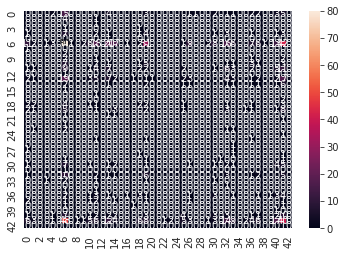

In [24]:
plt.Figure(figsize=(15, 15))

cm = confusion_matrix(test_targets_total, rfc.predict(test_inputs_total))
sn.heatmap(cm, annot=True)

#ax1.xlabel('Predicted Label')
plt.show()

In [ ]:
#lr_total = LogisticRegression(max_iter=1000, verbose=2) 32.4 at 2/3, 34%, 36,38.36%
#lr_total.fit(train_inputs_authors_resampled, train_targets_total_resampled)
#lr_total.score(test_inputs_total, test_inputs_total)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     14392975     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04651D+04    |proj g|=  2.90848D+09

At iterate    1    f=  1.03027D+04    |proj g|=  4.90256D+09

At iterate    2    f=  1.01639D+04    |proj g|=  2.86497D+09

At iterate    3    f=  1.00883D+04    |proj g|=  9.79688D+09


In [3]:
total_targets

NameError: name 'total_targets' is not defined